In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
from IPython.display import Audio
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, Model, optimizers

2022-02-08 10:53:53.398361: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-08 10:53:53.398401: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#Data Augmentation 
# Noise Injection 
#Shifting time 
#Changing the pitch 
#Speed 
# Time wrapping 
# Frequency Masking 
# Time Masking 

In [4]:
audio = "/home/divyansh/Divyansh/projects/senti_random_forest/data/"

In [5]:
audio_df = pd.read_csv('/home/divyansh/Divyansh/projects/senti_random_forest/audio.csv', usecols= ['emotion', 'path', 'gender', 'actor' ])

In [6]:
audio_df.head()

,gender,emotion,actor,path
0,male,neutral,1,/home/divyansh/Divyansh/projects/senti_random_...
1,male,fear,1,/home/divyansh/Divyansh/projects/senti_random_...
2,male,angry,1,/home/divyansh/Divyansh/projects/senti_random_...
3,male,happy,1,/home/divyansh/Divyansh/projects/senti_random_...
4,male,sad,1,/home/divyansh/Divyansh/projects/senti_random_...


In [7]:
train, test = train_test_split(audio_df, test_size=0.2, random_state= 0, 
                               stratify=audio_df[['emotion', 'gender', 'actor']])

In [8]:
X_train = train.iloc[:,3:]
y_train = train.iloc[:,:2].drop(columns = ['gender'])

In [9]:
print(X_train.shape)

(1152, 1)


Adding the noise, stretch, speed and Pitch to the audio file 


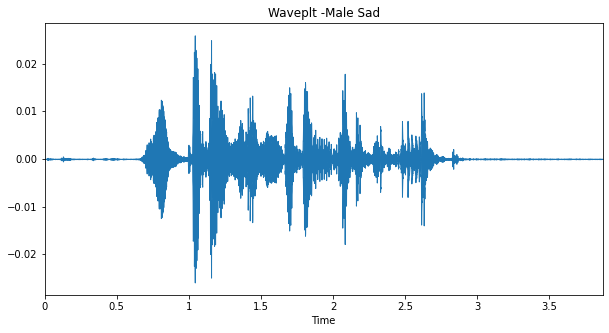

In [10]:
fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'
x,sr = librosa.load(fname)
plt.figure(figsize=(10,5))
librosa.display.waveplot(x,sr=sr)
plt.title('Waveplt -Male Sad')
plt.savefig('Waveplot_MaleSad.png')

In [11]:
#Adding the noise 
def noise(x):
    noise_amp = 0.05* np.random.uniform()*np.amax(x)
    x = x.astype('float64') + noise_amp * np.random.normal(size = x.shape[0])
    return x

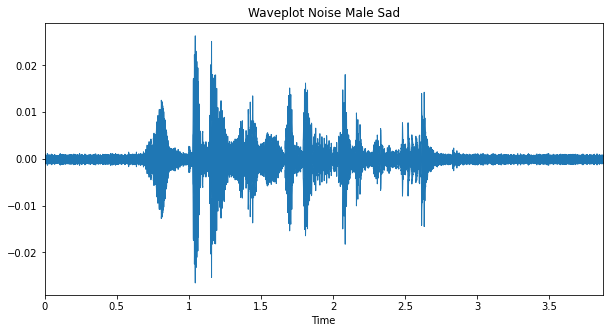

In [12]:
x = noise(x)
plt.figure(figsize=(10,5))
librosa.display.waveplot(x,sr=sr)
plt.title('Waveplot Noise Male Sad')
plt.savefig('Wave_MaleSadNoise.png')

In [13]:
#function to stretch the sound 
def stretch(x, rate=0.8):
    data = librosa.effects.time_stretch(x,rate)
    return data


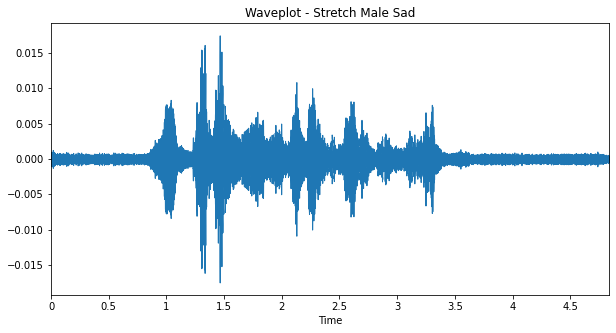

In [14]:
x = stretch(x)
plt.figure(figsize=(10,5))
librosa.display.waveplot(x,sr=sr)
plt.title('Waveplot - Stretch Male Sad')
plt.savefig('Waveplot_MaleSadStretch.png')


In [15]:
#function to increase the speed and the pitch 
def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4/ length_change
    tmp = np.interp(np.arange(0,len(x), speed_fac), np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x*=0
    x[0:minlen] = tmp[0:minlen]
    return x

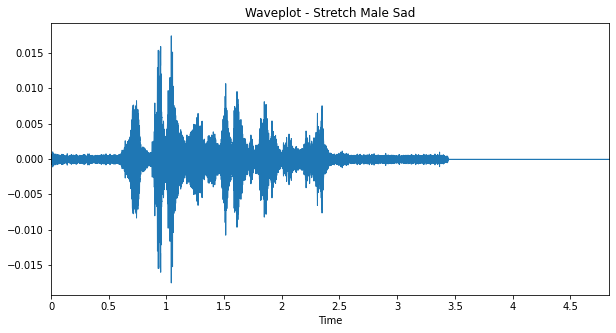

In [16]:
x = speedNpitch(x)
plt.figure(figsize=(10,5))
librosa.display.waveplot(x,sr=sr)
plt.title('Waveplot - Stretch Male Sad')
plt.savefig('Waveplot_MaleSpeedNPitch.png')


In [17]:
#Applying the Data Augmentation methods to train set 

df = pd.DataFrame(columns=['log_spec'])
counter = 0

for index,path in enumerate(train.path):
    #for the wave representation 
    X,sample_Rate = librosa.load(path, res_type='kaiser_fast', duration= 3, sr= 44100, offset= 0.5)
    spectogram = librosa.feature.melspectrogram(y=X, sr=sample_Rate, n_mels=128, fmax = 8000)
    db_spec = librosa.power_to_db(spectogram)
    log_spectogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectogram]
    counter += 1
print(len(df))
df.head()
    

1152


,log_spec
0,"[-67.48485, -67.48485, -67.48485, -67.48485, -..."
1,"[-70.23177, -69.54781, -69.33392, -69.498695, ..."
2,"[-61.203438, -61.185642, -56.77076, -54.75769,..."
3,"[-45.199844, -43.82312, -44.344078, -45.735817..."
4,"[-70.07283, -69.86238, -69.91055, -69.819855, ..."


In [18]:
# ADD NOISE AND USE FEATURE EXTRACTION
df_noise = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # noise 
    aug = noise(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_noise.loc[counter] = [aug]
    counter +=1
print(len(df_noise))
df_noise.head()
    
    

1152


,feature
0,"[-67.48485, -67.48485, -67.48485, -67.48485, -..."
1,"[-70.23177, -69.54781, -69.33392, -69.498695, ..."
2,"[-61.203438, -61.185642, -56.77076, -54.75769,..."
3,"[-45.199844, -43.82312, -44.344078, -45.735817..."
4,"[-70.07283, -69.86238, -69.91055, -69.819855, ..."


In [19]:
# ADD SPEED AND PITCH THEN USE FEATURE EXTRACTION
df_speedpitch = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # speed pitch
    aug = speedNpitch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_speedpitch.loc[counter] = [aug] 
    counter +=1
print(len(df_speedpitch))
df_speedpitch.head()

1152


,feature
0,"[-67.36716, -67.36716, -67.36716, -67.36716, -..."
1,"[-69.71177, -69.270515, -69.30212, -69.32284, ..."
2,"[-64.92431, -60.04144, -58.443054, -61.875095,..."
3,"[-45.77384, -44.82806, -46.570007, -46.920174,..."
4,"[-69.73547, -69.65592, -69.52606, -69.48784, -..."


In [20]:
# ADD STRETCH AND USE FEATURE EXTRACTION ON AUDIO FILES
df_stretch=pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # stretch
    aug= stretch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_stretch.loc[counter] = [aug] 
    counter +=1
print(len(df_stretch))
df_stretch.head()

1152


,feature
0,"[-67.48485, -67.48485, -67.48485, -67.48485, -..."
1,"[-70.23177, -69.54781, -69.33392, -69.498695, ..."
2,"[-61.203438, -61.185642, -56.77076, -54.75769,..."
3,"[-45.199844, -43.82312, -44.344078, -45.735817..."
4,"[-70.07283, -69.86238, -69.91055, -69.819855, ..."


In [22]:
#Combine the tables 
labels = train.emotion
labels.reset_index(drop= True, inplace=True)
labels

0          angry
1       surprise
2       surprise
3       surprise
4       surprise
          ...   
1147       angry
1148         sad
1149         sad
1150        calm
1151        fear
Name: emotion, Length: 1152, dtype: object

In [26]:
#DF[log_spec] + labels 
mfcc_df = pd.DataFrame(df['log_spec'].values.tolist())
mfcc = pd.concat([mfcc_df,labels], axis=1, ignore_index=True)
mfcc = mfcc.rename(index=str, columns={259: "emotion"})

In [27]:
mfcc

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
0,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,...,-62.060246,-63.543011,-64.174782,-65.487061,-64.988419,-65.060226,-66.019608,-66.003098,-66.185074,angry
1,-70.231773,-69.547813,-69.333923,-69.498695,-69.545044,-69.347542,-69.322182,-69.574738,-69.412376,-69.370827,...,-69.792244,-69.773430,-69.772911,-69.914490,-70.022072,-70.323563,-70.168869,-70.312294,-70.265297,surprise
2,-61.203438,-61.185642,-56.770760,-54.757690,-58.826164,-59.976463,-59.735039,-59.492882,-58.538071,-56.733864,...,-61.301632,-61.301632,-61.287701,-60.729000,-60.049236,-60.986099,-61.301632,-61.266155,-61.219494,surprise
3,-45.199844,-43.823120,-44.344078,-45.735817,-46.095490,-45.702011,-45.733891,-46.317333,-47.424995,-48.189751,...,-61.167828,-61.031166,-60.674316,-60.724525,-60.864182,-60.995823,-61.174706,-61.302704,-61.302704,surprise
4,-70.072830,-69.862381,-69.910553,-69.819855,-69.711555,-69.769562,-69.795105,-69.901276,-69.722412,-69.809959,...,-68.400688,-68.543983,-68.579926,-68.378090,-68.584686,-69.101562,-69.075272,-69.198105,-69.169342,surprise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,-45.475925,-45.482555,-45.482555,-45.482555,-45.482555,-45.478024,-45.447929,-45.268700,-45.243233,-45.291142,...,-30.661184,-32.678814,-34.794762,-36.341885,-37.813972,-38.328606,-39.064583,-40.051395,-40.789944,angry
1148,-66.688438,-66.651245,-67.557022,-67.570343,-67.880669,-68.421379,-68.626846,-68.945663,-69.183342,-69.000572,...,-69.669334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sad
1149,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,...,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,sad
1150,-79.743843,-78.552917,-78.477829,-78.209030,-78.184258,-79.843422,-79.147881,-79.930328,-80.102211,-79.086334,...,-80.547226,-80.879211,-79.456299,-80.065697,-79.707115,-79.203743,-79.565636,-79.188126,-78.859329,calm


In [29]:
noise_df = pd.DataFrame(df_noise['feature'].values.tolist())
noise = pd.concat([noise_df,labels], axis=1)
noise = noise.rename(index=str, columns={259: "label"})

In [30]:
noise

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
0,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,-67.484848,...,-62.060246,-63.543011,-64.174782,-65.487061,-64.988419,-65.060226,-66.019608,-66.003098,-66.185074,angry
1,-70.231773,-69.547813,-69.333923,-69.498695,-69.545044,-69.347542,-69.322182,-69.574738,-69.412376,-69.370827,...,-69.792244,-69.773430,-69.772911,-69.914490,-70.022072,-70.323563,-70.168869,-70.312294,-70.265297,surprise
2,-61.203438,-61.185642,-56.770760,-54.757690,-58.826164,-59.976463,-59.735039,-59.492882,-58.538071,-56.733864,...,-61.301632,-61.301632,-61.287701,-60.729000,-60.049236,-60.986099,-61.301632,-61.266155,-61.219494,surprise
3,-45.199844,-43.823120,-44.344078,-45.735817,-46.095490,-45.702011,-45.733891,-46.317333,-47.424995,-48.189751,...,-61.167828,-61.031166,-60.674316,-60.724525,-60.864182,-60.995823,-61.174706,-61.302704,-61.302704,surprise
4,-70.072830,-69.862381,-69.910553,-69.819855,-69.711555,-69.769562,-69.795105,-69.901276,-69.722412,-69.809959,...,-68.400688,-68.543983,-68.579926,-68.378090,-68.584686,-69.101562,-69.075272,-69.198105,-69.169342,surprise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,-45.475925,-45.482555,-45.482555,-45.482555,-45.482555,-45.478024,-45.447929,-45.268700,-45.243233,-45.291142,...,-30.661184,-32.678814,-34.794762,-36.341885,-37.813972,-38.328606,-39.064583,-40.051395,-40.789944,angry
1148,-66.688438,-66.651245,-67.557022,-67.570343,-67.880669,-68.421379,-68.626846,-68.945663,-69.183342,-69.000572,...,-69.669334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sad
1149,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,...,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,sad
1150,-79.743843,-78.552917,-78.477829,-78.209030,-78.184258,-79.843422,-79.147881,-79.930328,-80.102211,-79.086334,...,-80.547226,-80.879211,-79.456299,-80.065697,-79.707115,-79.203743,-79.565636,-79.188126,-78.859329,calm


In [31]:
stretch_df = pd.DataFrame(df_stretch['feature'].values.tolist())
stretch = pd.concat([stretch_df,labels], axis=1)
stretch = noise.rename(index=str, columns={259: "label"})

In [32]:
speedpitch_df = pd.DataFrame(df_speedpitch['feature'].values.tolist())
speedpitch = pd.concat([speedpitch_df,labels], axis=1)
speedpitch = noise.rename(index=str, columns={259: "label"})

In [33]:
conbined_df = pd.concat([mfcc,noise, speedpitch, stretch], ignore_index=True)
conbined_df = conbined_df.fillna(0)
conbined_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
4603,-45.475925,-45.482555,-45.482555,-45.482555,-45.482555,-45.478024,-45.447929,-45.268700,-45.243233,-45.291142,...,-30.661184,-32.678814,-34.794762,-36.341885,-37.813972,-38.328606,-39.064583,-40.051395,-40.789944,angry
4604,-66.688438,-66.651245,-67.557022,-67.570343,-67.880669,-68.421379,-68.626846,-68.945663,-69.183342,-69.000572,...,-69.669334,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sad
4605,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,...,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,-79.944366,sad
4606,-79.743843,-78.552917,-78.477829,-78.209030,-78.184258,-79.843422,-79.147881,-79.930328,-80.102211,-79.086334,...,-80.547226,-80.879211,-79.456299,-80.065697,-79.707115,-79.203743,-79.565636,-79.188126,-78.859329,calm
4607,-49.112339,-48.740860,-48.975597,-48.741455,-48.503597,-48.285568,-48.010487,-47.421593,-47.698982,-48.960796,...,-22.875202,-17.828232,-15.137363,-14.098281,-14.509683,-16.567663,-18.243511,-16.837927,-15.387573,fear


In [34]:
X_train = conbined_df.iloc[:,:-1]
y_train = conbined_df.iloc[:,-1:]

In [35]:
#Feature Extraction for test set 
df = pd.DataFrame(columns=['mel_spectogram'])
counter = 0

for index,path in enumerate(test.path):
    #for the wave representation 
    X,sample_Rate = librosa.load(path, res_type='kaiser_fast', duration= 3, sr= 44100, offset= 0.5)
    spectogram = librosa.feature.melspectrogram(y=X, sr=sample_Rate, n_mels=128, fmax = 8000)
    db_spec = librosa.power_to_db(spectogram)
    log_spectogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectogram]
    counter += 1
print(len(df))
df.head()
    


288


,mel_spectogram
0,"[-63.772854, -63.772854, -63.772854, -63.77285..."
1,"[-67.33584, -67.29651, -67.68796, -68.46303, -..."
2,"[-52.238705, -52.015965, -51.746494, -51.12382..."
3,"[-47.162098, -47.162098, -47.162098, -47.16209..."
4,"[-71.59723, -71.59723, -71.59723, -71.59723, -..."


In [36]:
test.reset_index(drop=True, inplace=True)

In [37]:
df_combined = pd.concat([test,pd.DataFrame(df['mel_spectogram'].values.tolist())], axis= 1)
df_combined = df_combined.fillna(0)
df_combined.head()

,gender,emotion,actor,path,0,1,2,3,4,5,...,249,250,251,252,253,254,255,256,257,258
0,female,fear,4,/home/divyansh/Divyansh/projects/senti_random_...,-63.772854,-63.772854,-63.772854,-63.772854,-63.772854,-63.772854,...,-63.585510,-63.753170,-63.772854,-63.772854,-63.761829,-63.660069,-63.637070,0.000000,0.000000,0.000000
1,male,calm,21,/home/divyansh/Divyansh/projects/senti_random_...,-67.335838,-67.296509,-67.687958,-68.463028,-68.613678,-68.468452,...,-72.323189,-71.582573,-71.443985,-71.736214,-72.236641,-71.859688,-71.247467,-71.219315,-71.554245,-71.173882
2,female,happy,16,/home/divyansh/Divyansh/projects/senti_random_...,-52.238705,-52.015965,-51.746494,-51.123821,-50.795700,-50.652802,...,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944
3,female,angry,12,/home/divyansh/Divyansh/projects/senti_random_...,-47.162098,-47.162098,-47.162098,-47.162098,-47.162098,-47.162098,...,-46.379883,-46.451462,-46.434490,-46.435925,-46.471390,-46.708366,-46.792576,-46.639893,-46.397442,-46.686069
4,male,fear,23,/home/divyansh/Divyansh/projects/senti_random_...,-71.597229,-71.597229,-71.597229,-71.597229,-71.597229,-71.597229,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [38]:
df_combined.drop(columns='path', inplace=True)

In [39]:
print(df_combined.shape)
df_combined.head()

(288, 262)


,gender,emotion,actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,female,fear,4,-63.772854,-63.772854,-63.772854,-63.772854,-63.772854,-63.772854,-63.772854,...,-63.585510,-63.753170,-63.772854,-63.772854,-63.761829,-63.660069,-63.637070,0.000000,0.000000,0.000000
1,male,calm,21,-67.335838,-67.296509,-67.687958,-68.463028,-68.613678,-68.468452,-68.486153,...,-72.323189,-71.582573,-71.443985,-71.736214,-72.236641,-71.859688,-71.247467,-71.219315,-71.554245,-71.173882
2,female,happy,16,-52.238705,-52.015965,-51.746494,-51.123821,-50.795700,-50.652802,-50.606216,...,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944
3,female,angry,12,-47.162098,-47.162098,-47.162098,-47.162098,-47.162098,-47.162098,-47.162098,...,-46.379883,-46.451462,-46.434490,-46.435925,-46.471390,-46.708366,-46.792576,-46.639893,-46.397442,-46.686069
4,male,fear,23,-71.597229,-71.597229,-71.597229,-71.597229,-71.597229,-71.597229,-71.597229,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [40]:
X_test = df_combined.iloc[:,3:]
y_test = df_combined.iloc[:,:2].drop(columns = ['gender'])

In [41]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std 
X_test = (X_test - mean)/std

In [42]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [43]:
y_train

array([['angry'],
       ['surprise'],
       ['surprise'],
       ...,
       ['sad'],
       ['calm'],
       ['fear']], dtype=object)

In [44]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [45]:
print(y_test[0:10])

[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


In [46]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [47]:
#Reshape to tranform the dimensions to have 3D tensors

X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_test.shape

(288, 259, 1)

In [48]:
X_train.shape


(4608, 259, 1)